In [4]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)
library(gridExtra,quietly = T)

In [5]:
#head(cancer_cases)
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")


[1]  863 2210

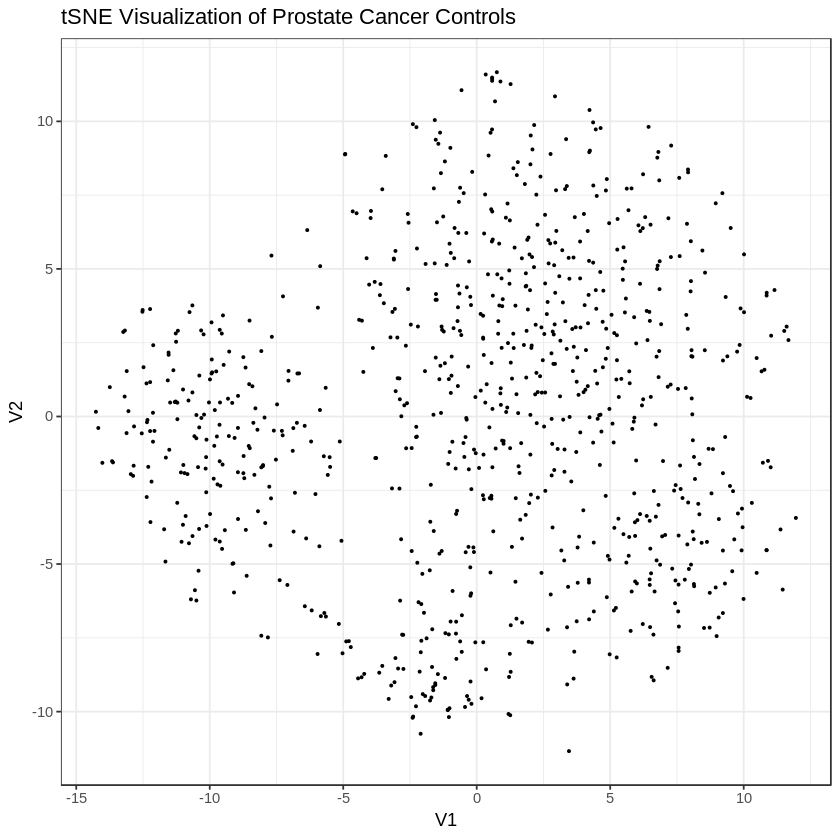

In [6]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#cluster based on cases

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Controls") +
  scale_colour_brewer(palette = "Set2")

DBSCAN clustering for 863 objects.
Parameters: eps = 1.5, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 474 116 167 

Available fields: cluster, eps, minPts

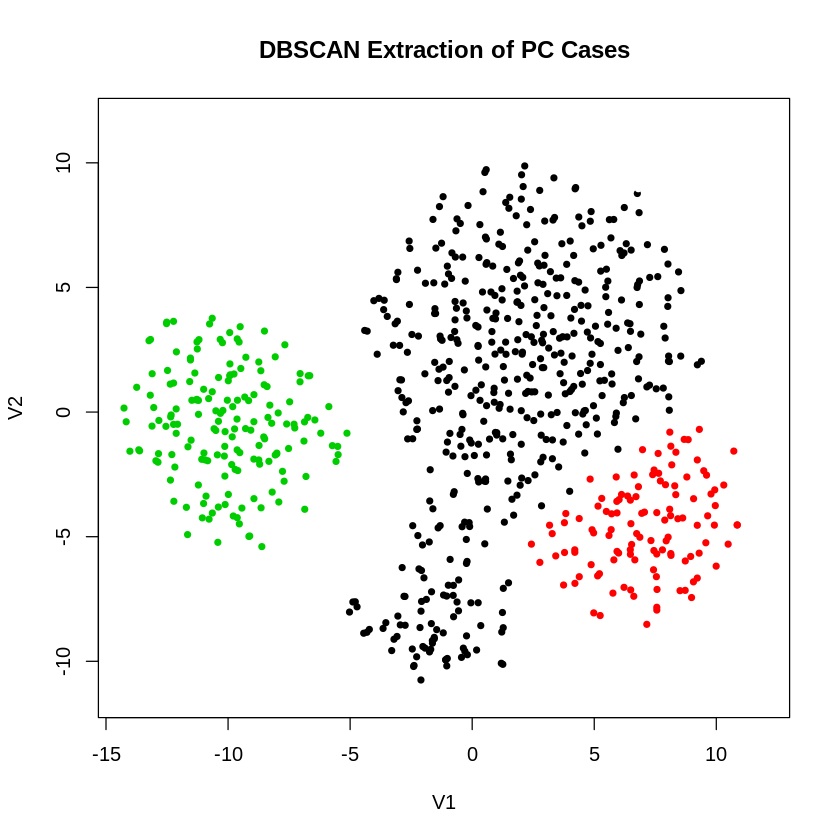

In [7]:
res <- dbscan::dbscan(d_tsne_3,eps = 1.5, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC Cases")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

In [8]:
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3) 

V1,V2,cluster,ID
-1.3959189,-4.6476141,1,PC_Pair_1
-14.2628937,0.1604518,3,PC_Pair_2
3.5794374,2.9629831,1,PC_Pair_3
5.9716910,-1.4912276,1,PC_Pair_4
6.3676282,3.5761073,1,PC_Pair_5
0.5680226,5.9295431,1,PC_Pair_6


In [9]:
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]


In [10]:
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

In [11]:
#cancer_cases_controls_avg$VTRNA2.1 <- NULL
#cancer_cases_controls_avg$DUSP22 <- NULL

In [12]:

cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]

In [13]:
cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]

## Cases in Cluster 1  and matching controls

In [14]:
head(cluster1_cases)
head(cluster1_controls)


,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4350,Sample_4350,PC,1,PC_Pair_1,2,Never,0.03124907,28.51924,0.4788985,0.00000000,⋯,1.2262072,0.8556876,1.0768256,-0.9672918,2.2953312,3.557203,1.5330157,-1.744068,0.5329113,0.968932779
4353,Sample_4353,PC,1,PC_Pair_3,1,Never,0.10082223,30.05003,0.1844862,0.12306696,⋯,1.6851114,0.1400600,0.6258309,-0.1437234,3.1403654,2.954671,1.9219780,-3.259399,0.1057944,0.002889846
4355,Sample_4355,PC,1,PC_Pair_4,2,Former,0.06004972,27.90445,0.1091810,0.07194285,⋯,2.4120595,0.5453855,0.7982160,-0.9299917,3.1558635,3.003048,0.5877212,-2.936598,0.8860706,0.326238155
4358,Sample_4358,PC,1,PC_Pair_5,1,Never,0.11303621,26.42713,0.1657279,0.08150207,⋯,2.2369826,0.5265385,0.8642715,-0.5512491,0.8518819,3.064723,-0.9403711,-3.147413,-3.2661796,-1.392128455
4360,Sample_4360,PC,1,PC_Pair_6,4,Never,0.08055555,41.52421,0.1275946,0.09060549,⋯,-0.4110105,0.4845656,0.7149950,-0.7424551,1.6664075,2.882332,1.9814976,-3.757477,0.7106879,0.289179001
4364,Sample_4364,PC,1,PC_Pair_8,1,Never,0.06817594,26.79123,0.3080299,0.15967438,⋯,2.3224883,0.5681482,0.4236015,0.8411062,1.1290718,3.737171,0.5636090,-1.874462,-2.6261978,-0.093592184


,Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4349,Sample_4349,PC,0,PC_Pair_1,2,Never,0.02630550,23.80933,0.12668227,0.03316347,⋯,1.5457311,0.5469304,0.4910751,-1.7315195,0.8757137,3.082579,0.9575129,-3.435569,0.2141593,0.24575722
4354,Sample_4354,PC,0,PC_Pair_3,4,Never,0.05037990,25.58598,0.17959327,0.08882190,⋯,3.5004475,0.5856435,0.4211313,-1.4144366,3.2269144,3.245901,1.3239087,-3.986961,-1.7764825,-0.09075481
4356,Sample_4356,PC,0,PC_Pair_4,1,Never,0.11050807,30.67739,0.18013556,0.11107306,⋯,1.9433960,0.7128411,0.9361930,-0.1942653,3.0680312,3.059673,0.5933022,-3.817015,0.7982271,0.68652489
4357,Sample_4357,PC,0,PC_Pair_5,4,Former,0.04248149,29.10325,0.06717147,0.17098801,⋯,1.8049348,0.8185096,0.6725335,0.4012593,1.8933872,2.858437,1.1962743,-3.069210,0.7699756,-1.87176098
4359,Sample_4359,PC,0,PC_Pair_6,3,Former,0.09378724,28.26854,0.18097590,0.17949657,⋯,0.8035994,0.7665506,1.0434265,0.1836838,2.9495923,3.159290,1.6828115,-3.790084,-0.2694896,1.59295572
4363,Sample_4363,PC,0,PC_Pair_8,2,Current,0.05813113,26.67719,0.14146970,0.02430881,⋯,2.4150536,0.4420934,1.1291105,-0.5973236,3.8636715,3.376041,1.7665025,-3.717542,-2.5005084,-0.15991261


In [15]:
cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)


cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

cluster1_data$cluster <- rep("C1",dim(cluster1_data)[1])
cluster2_data$cluster <- rep("C2",dim(cluster2_data)[1])
cluster3_data$cluster <- rep("C3",dim(cluster3_data)[1])

In [16]:
all_cluster_data <- rbind(cluster1_data,cluster2_data,cluster3_data)


# Machine Learning algorithms for Classiciation

# 1. Feature Selection using Partial Lease Squares (PLS)  Algorithm 

In [17]:
for (cluster_id in c("C1","C2","C3")){
    print(paste0("Running PLS  Feature selection algorithm for ",cluster_id))
    df <- all_cluster_data[all_cluster_data$cluster==cluster_id,]
    df$CaseControl <- as.factor(df$CaseContro)
    df$cluster <- NULL
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    plot(mod1)
    print(varImp(mod1))

}

[1] "Running PLS  Feature selection algorithm for C1"



Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22        100.00
VTRNA2.1       98.15
CYP4V2         27.93
LOC440910      24.97
LDHC           23.81
CCDC144NL      22.77
DOC2GP         22.38
LY6G5C         21.31
SIM2           20.52
LOC100128885   20.16
RIMS4          19.89
PSCA           19.17
CABLES1        18.49
C2orf69        17.87
C17orf98       17.67
IZUMO2         17.62
GSTM5          17.59
CTBP1.AS2      17.18
LOC100506159   16.69
FGF12          16.68
[1] "Running PLS  Feature selection algorithm for C2"
pls variable importance

  only 20 most important variables shown (out of 145)

                  Overall
DUSP22             100.00
VTRNA2.1            30.71
LCLAT1              18.51
C4B.C4B_2           17.86
RIMS4               17.23
HCG4B               16.72
LOC440910           15.34
GSTM5               14.52
PARD6G.PARD6G.AS1   14.19
PARD6G              14.19
PSORS1C3            13.93
LY6G5C              13.53
TCEB3B 

# Cluster 1 Case/Control comparison w.r.t DUSP22 and VTRNA2-1

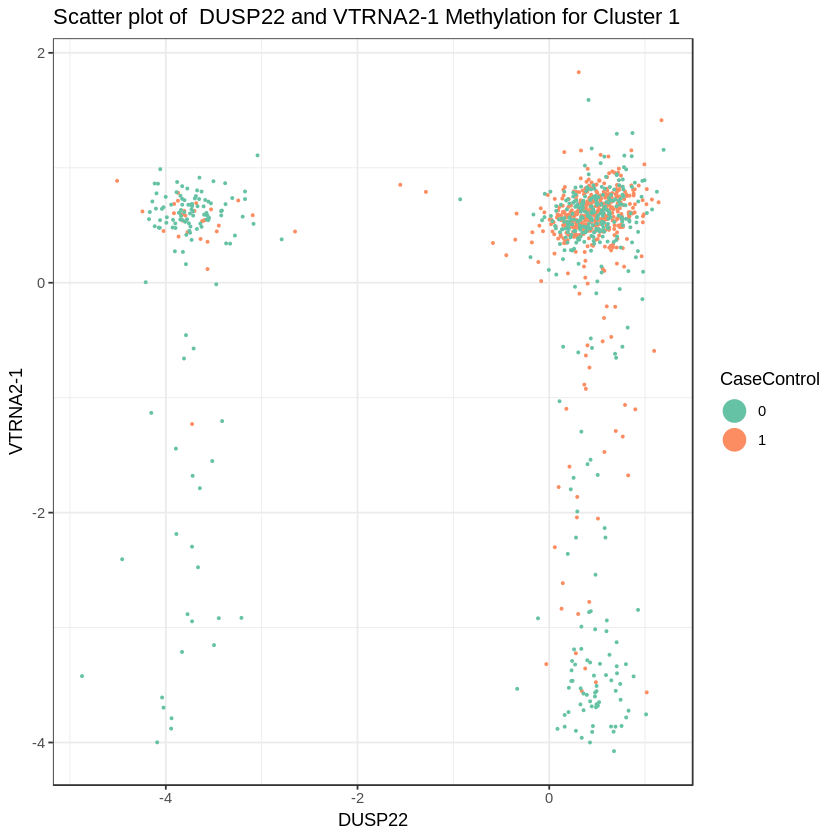

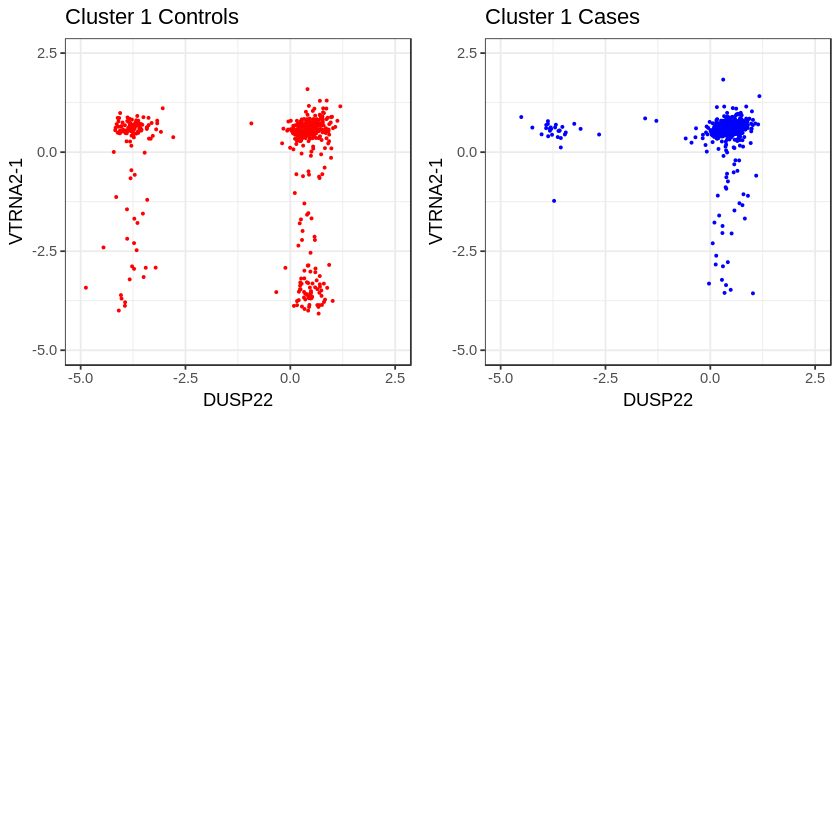

In [18]:
test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of  DUSP22 and VTRNA2-1 Methylation for Cluster 1") +
scale_colour_brewer(palette = "Set2")
print(g)

test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_1 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_1 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_1, g1_1, ncol=2,nrow=2)

# Cluster 2 Case/Control comparison w.r.t DUSP22 and VTRNA2-1

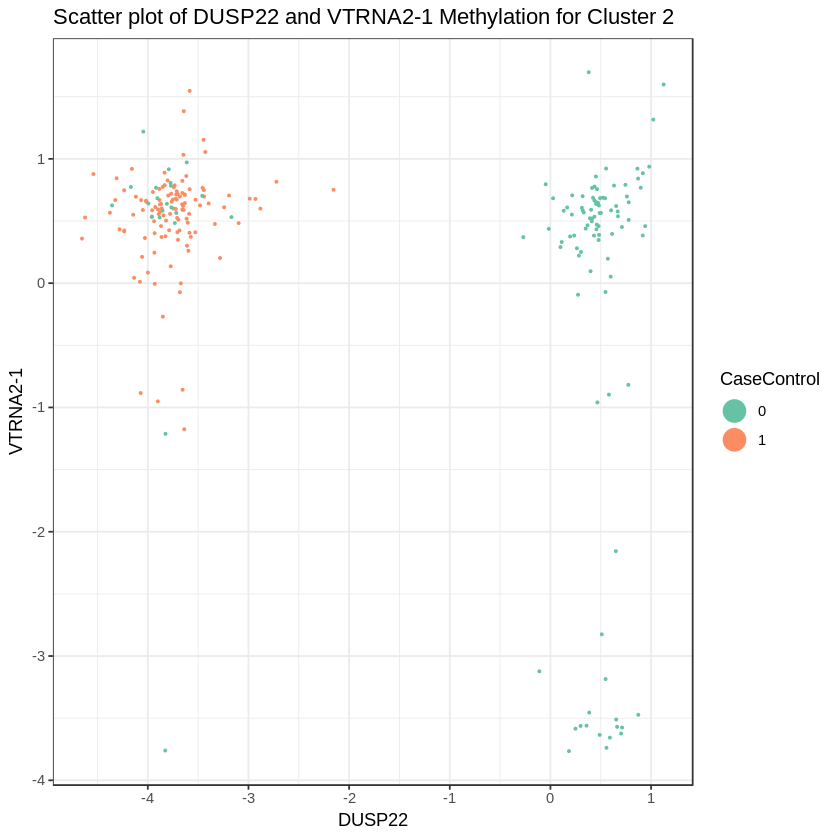

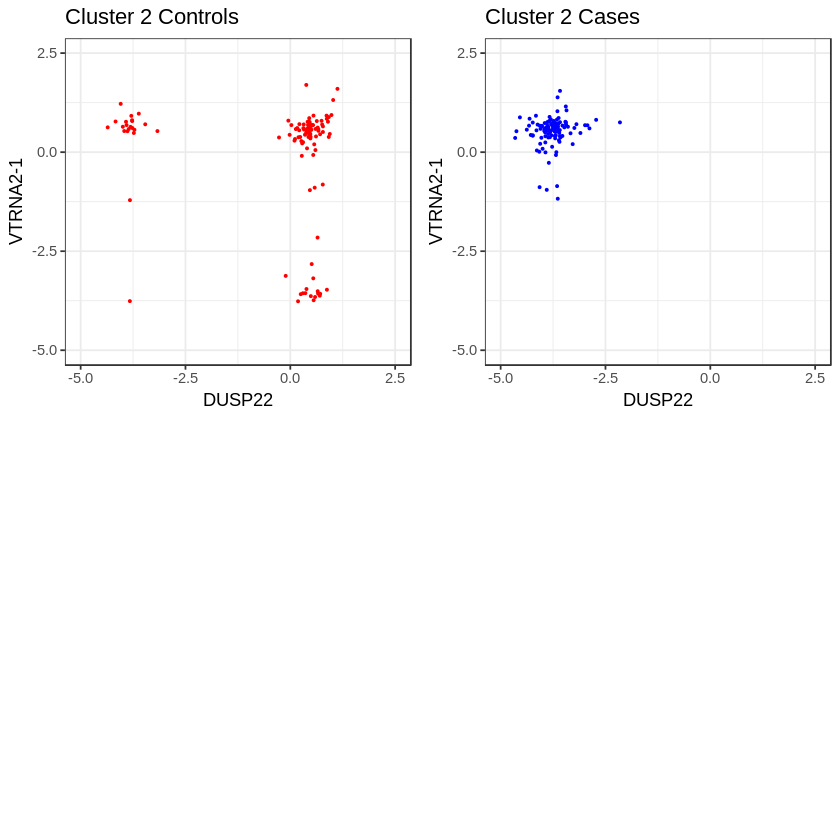

In [19]:
test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of DUSP22 and VTRNA2-1 Methylation for Cluster 2") +
scale_colour_brewer(palette = "Set2")
print(g)

test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_2 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_2 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_2, g1_2, ncol=2,nrow=2)

# Cluster 3 Case/Control comparison w.r.t DUSP22 and VTRNA2-1

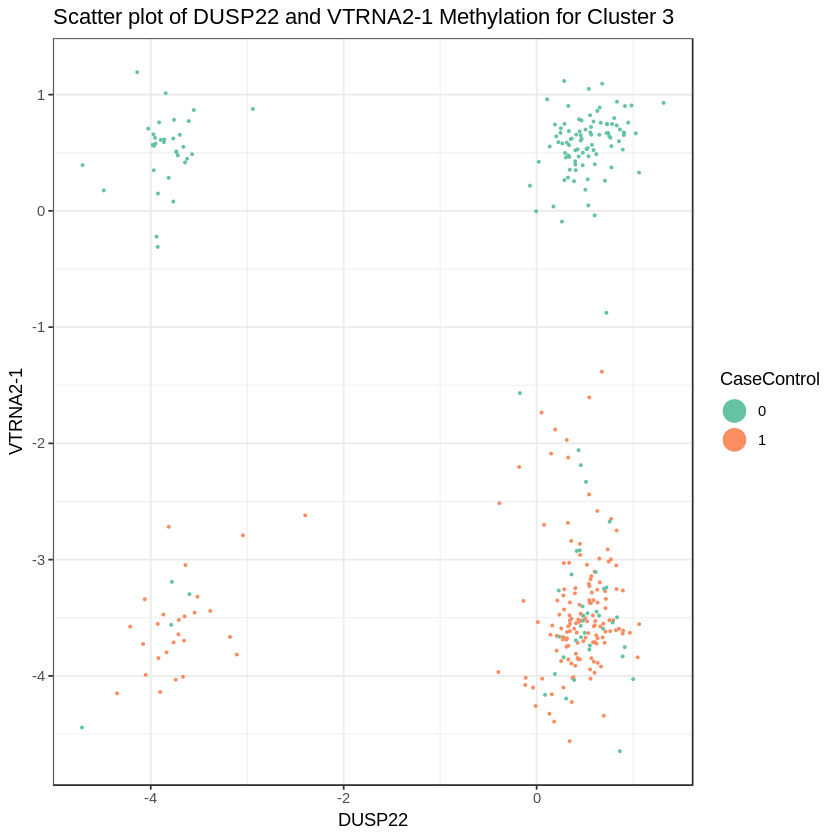

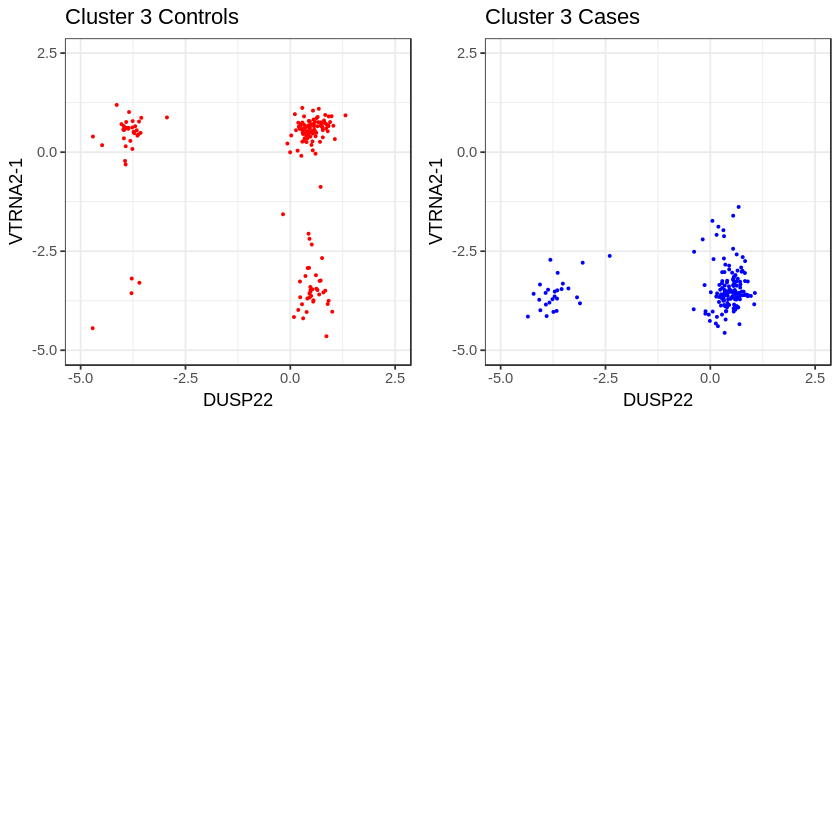

In [20]:
test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of DUSP22 and VTRNA2-1 Methylation for Cluster 3") +
scale_colour_brewer(palette = "Set2")
print(g)
test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_3 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_3 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_3, g1_3, ncol=2,nrow=2)

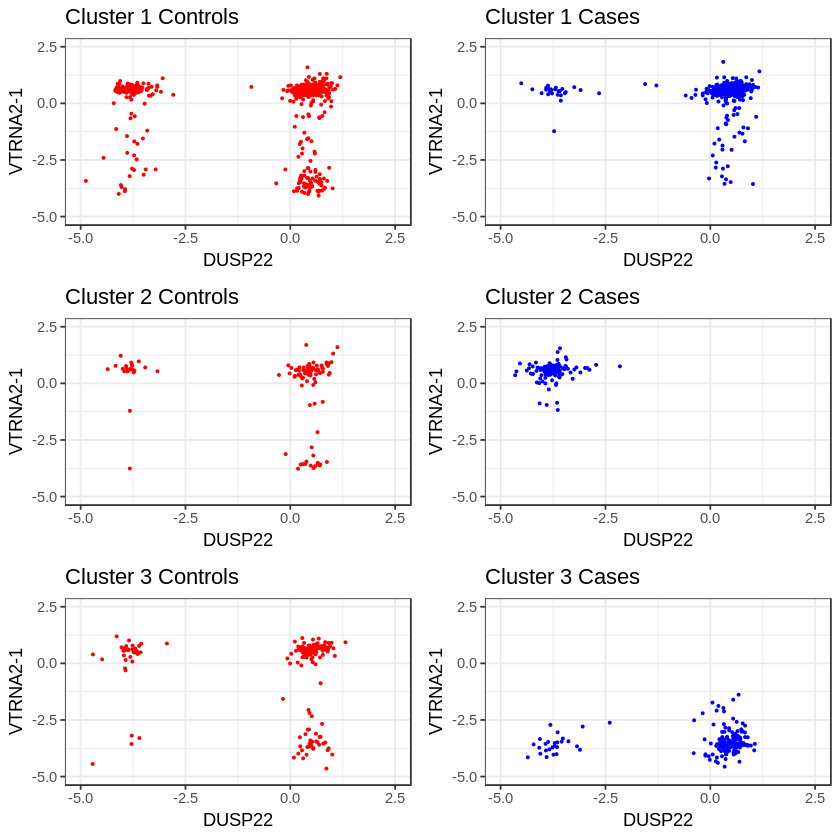

In [21]:
grid.arrange(g0_1,g1_1,g0_2,g1_2,g0_3,g1_3, ncol=2,nrow=3)

# Each Cluster of CASES vs the rest of CASES

# Cluser 1 vs Rest 

In [22]:
cluster1_cases$cluster <- rep("C1",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C2_3",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C2_3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))

pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
VTRNA2.1     100.000
DUSP22        84.303
CYP2E1_clus2  14.365
DUSP5P1       13.265
CYP2E1_clus1  12.984
ERICH1        12.729
EXOC1         12.376
GSTM5         12.270
C7orf49       12.251
LINC01169     11.406
PIWIL1_clus1  11.330
SIM2          11.221
TSKS          11.147
ANKRD30B      10.281
LOC440910     10.230
ZFP57         10.140
LHX8          10.072
CCDC144NL     10.068
ZFYVE28       10.025
ATP11A         9.201


# Cluster 2 vs Rest

In [23]:
cluster1_cases$cluster <- rep("C1_3",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C2",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C1_3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))



pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22       100.000
VTRNA2.1      28.804
DUSP5P1       12.554
EXOC1         11.429
KIAA1875      10.962
C7orf49       10.517
LY6G5C         9.629
NOX5           9.451
USP6           9.232
CD177          9.032
CYP2E1_clus2   9.023
PF4            8.911
ACADM          8.807
ANKRD20A11P    8.306
GSTM5          7.744
ERICH1         7.733
CCDC144NL      7.591
CCKBR          7.562
TCEB3B         7.224
ATP11A         7.170


# Cluster 3 vs Rest

In [24]:
cluster1_cases$cluster <- rep("C1_2",dim(cluster1_cases)[1])
cluster2_cases$cluster <- rep("C1_2",dim(cluster2_cases)[1])
cluster3_cases$cluster <- rep("C3",dim(cluster3_cases)[1])

cluster1_vsRest <- rbind(cluster1_cases,cluster2_cases,cluster3_cases)
cluster1_vsRest <- subset(cluster1_vsRest,select = -c(Sample,ID,CaseControl,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_vsRest$cluster <- as.factor(cluster1_vsRest$cluster)
myfolds <- createMultiFolds(cluster1_vsRest$cluster, k = 5, times = 10)
control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")
# Train PLS model
mod1 <- train(cluster ~ ., data = cluster1_vsRest,
 method = "pls",
 metric = "Accuracy",
 tuneLength = 20,
 trControl = control,
 preProc = c("zv","center","scale"))
# Check CV profile
#plot(mod1)
print(varImp(mod1))


pls variable importance

  only 20 most important variables shown (out of 145)

                           Overall
VTRNA2.1                   100.000
EXOC1                       12.724
C7orf49                     12.294
PIWIL1_clus1                10.144
DUSP5P1                      9.200
SIM2                         9.199
DUSP22                       8.980
ZFYVE28                      8.802
ATP11A                       8.753
CYP2E1_clus1                 8.336
LINC01169                    7.824
LOC652276                    7.797
CCKBR                        7.362
ANKDD1B                      7.228
CABLES1                      7.069
MOBP                         6.898
CYP2E1_clus2                 6.896
LOC101928979.NBPF20.NBPF10   6.622
CD177                        6.619
ANKRD30B                     6.474


# Condi. Logistic Regression model with Interaction 

In [34]:
library(survival)
cancer_cases_controls_avg_PC <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC",]


Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster



In [35]:
dataset1 <- cancer_cases_controls_avg_PC[c("CaseControl","ID","VTRNA2.1","DUSP22")]


In [36]:
res.clogit <- clogit(CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22 + strata(ID), dataset1)

In [37]:
summary(res.clogit)

Call:
coxph(formula = Surv(rep(1, 1726L), CaseControl) ~ VTRNA2.1 + 
    DUSP22 + VTRNA2.1:DUSP22 + strata(ID), data = dataset1, method = "exact")

  n= 1726, number of events= 863 

                     coef exp(coef)  se(coef)      z Pr(>|z|)  
VTRNA2.1        -0.056093  0.945452  0.030729 -1.825   0.0679 .
DUSP22          -0.009023  0.991018  0.026515 -0.340   0.7336  
VTRNA2.1:DUSP22  0.011601  1.011668  0.017675  0.656   0.5116  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                exp(coef) exp(-coef) lower .95 upper .95
VTRNA2.1           0.9455     1.0577    0.8902     1.004
DUSP22             0.9910     1.0091    0.9408     1.044
VTRNA2.1:DUSP22    1.0117     0.9885    0.9772     1.047

Rsquare= 0.003   (max possible= 0.5 )
Likelihood ratio test= 4.74  on 3 df,   p=0.2
Wald test            = 4.68  on 3 df,   p=0.2
Score (logrank) test = 4.72  on 3 df,   p=0.2


# Logistic Regression within each case/control cluster

In [38]:
test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
res.logit1 <- glm(CaseControl ~ VTRNA2.1 +DUSP22+ VTRNA2.1:DUSP22, test_VT_DUSP, family = binomial(link = "logit"))
summary(res.logit1)


Call:
glm(formula = CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22, 
    family = binomial(link = "logit"), data = test_VT_DUSP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6300  -1.2889   0.2686   1.0049   2.1374  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.036929   0.073285  -0.504    0.614    
VTRNA2.1         0.511465   0.072219   7.082 1.42e-12 ***
DUSP22           0.397999   0.060101   6.622 3.54e-11 ***
VTRNA2.1:DUSP22 -0.006169   0.071014  -0.087    0.931    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1314.2  on 947  degrees of freedom
Residual deviance: 1175.1  on 944  degrees of freedom
AIC: 1183.1

Number of Fisher Scoring iterations: 5


In [39]:
test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
res.logit1 <- glm(CaseControl ~ VTRNA2.1 +DUSP22+ VTRNA2.1:DUSP22, test_VT_DUSP, family = binomial(link = "logit"))
summary(res.logit1)


Call:
glm(formula = CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22, 
    family = binomial(link = "logit"), data = test_VT_DUSP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3243  -0.1581   0.1528   0.5647   1.3657  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -4.4793     1.7202  -2.604 0.009217 ** 
VTRNA2.1          1.3476     2.1800   0.618 0.536486    
DUSP22           -1.5933     0.4593  -3.469 0.000522 ***
VTRNA2.1:DUSP22   0.2464     0.5785   0.426 0.670125    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 321.62  on 231  degrees of freedom
Residual deviance: 126.23  on 228  degrees of freedom
AIC: 134.23

Number of Fisher Scoring iterations: 9


In [40]:
test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
res.logit1 <- glm(CaseControl ~ VTRNA2.1 +DUSP22+ VTRNA2.1:DUSP22, test_VT_DUSP, family = binomial(link = "logit"))
summary(res.logit1)


Call:
glm(formula = CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22, 
    family = binomial(link = "logit"), data = test_VT_DUSP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6603  -0.2473   0.1168   0.6298   1.6728  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.89319    0.44177  -6.549 5.79e-11 ***
VTRNA2.1        -1.24495    0.13827  -9.004  < 2e-16 ***
DUSP22           0.20357    0.32581   0.625    0.532    
VTRNA2.1:DUSP22  0.08731    0.10030   0.870    0.384    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 463.02  on 333  degrees of freedom
Residual deviance: 227.71  on 330  degrees of freedom
AIC: 235.71

Number of Fisher Scoring iterations: 6


# Random Forest Classification AUC within each case/control cluster

# Cluster 1 RF model classification AUC

In [41]:
aucs <-c()
for(iter in 1:10){
cluster1_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster1_data))
train_ind <- sample(seq_len(nrow(cluster1_data)), size = smp_size)
train <- cluster1_data[train_ind, ]
test <- cluster1_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5074  0.5481  0.5691  0.5661  0.5763  0.6113 

# Cluster 2 RF model classification AUC

In [42]:
aucs <-c()
for(iter in 1:10){
cluster2_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster2_data))
train_ind <- sample(seq_len(nrow(cluster2_data)), size = smp_size)
train <- cluster2_data[train_ind, ]
test <- cluster2_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6529  0.7197  0.7711  0.7616  0.8123  0.8308 

# Cluster 3 RF model classification AUC

In [43]:
aucs <-c()
for(iter in 1:10){
cluster3_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster3_data))
train_ind <- sample(seq_len(nrow(cluster3_data)), size = smp_size)
train <- cluster3_data[train_ind, ]
test <- cluster3_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6522  0.7210  0.7584  0.7555  0.7830  0.8403 

# AUC is lower that I reported earlier because I used the averaged the probes within ESS/SIV, I the random forest again with probs to make sure that is the reason.

In [44]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==1,]
cancer_controls <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]

In [45]:
cluster1_cases <- cancer_cases[cancer_cases$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases[cancer_cases$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases[cancer_cases$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls[cancer_controls$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls[cancer_controls$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls[cancer_controls$ID %in% tsne_model_cluster3$ID,]

In [61]:
nums <- unlist(lapply(cluster3_data[,-1], is.numeric))
cluster3_data <- cluster3_data[,nums]
cluster3_data <- cluster3_data[ , colSums(is.na(cluster3_data)) == 0]

In [63]:
aucs <-c()
for(iter in 1:10){
cluster3_data$cluster <-NULL
smp_size <- floor(0.75 * nrow(cluster3_data))
train_ind <- sample(seq_len(nrow(cluster3_data)), size = smp_size)
train <- cluster3_data[train_ind, ]
test <- cluster3_data[-train_ind, ]
rf_model=randomForest(as.factor(CaseControl) ~.,data = train,ntree=200,mtry=2,importance=TRUE)
#rf_model
prediction <- predict(rf_model,subset(test,select = -c(CaseControl)))
table(observed = test$CaseControl,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(CaseControl)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$CaseControl))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$CaseControl==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
options(repr.plot.width=4, repr.plot.height=4)
#plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
#print(auc.perf@y.values)
    aucs <-c(aucs,auc.perf@y.values)
    }
summary(unlist(aucs))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5698  0.5698  0.5698  0.5698  0.5698  0.5698 